In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal 
from scipy.special import logsumexp
from numpy import random as rnd
import math
from scipy import stats
from sklearn.mixture import GaussianMixture

In [24]:
tsnv = pd.read_csv("Data/tsnv.csv")
tsnv.columns = ['x1', 'x2']
moon = pd.read_csv("Data/moon.csv")
elliptical = pd.read_csv("Data/elliptical.csv")
circle = pd.read_csv("Data/circle.csv")
blobs = pd.read_csv("Data/blobs.csv")


In [25]:
x = elliptical['x1']
y = elliptical['x2']

Data = [x,y]
Data = np.array(Data).T

In [26]:
Data

array([[ 3.29926, -4.21499],
       [-1.42316,  1.75409],
       [-2.03089,  5.86884],
       ...,
       [-3.24315,  5.74052],
       [-3.09304,  3.65991],
       [-1.38596,  2.11344]])

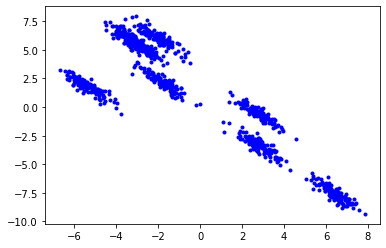

In [27]:
plt.figure()
plt.plot(Data[:,0],Data[:,1],'b.')
plt.show()


In [28]:
def FirstRandom():
    fay = random.uniform(0,1)
    miooZero = [rnd.normal(0, 1),rnd.normal(0, 1)]
    miooZero = np.array(miooZero)
    miooOne = [rnd.normal(0, 1),rnd.normal(0, 1)]
    miooOne = np.array(miooOne)
    a = rnd.normal(0,1, size=(2,2))
    b = rnd.normal(0,1, size=(2,2))
    sigZero = np.dot(a,a.T)
    sigOne = np.dot(b,b.T)
    initials = {'fay':fay , 'miooOne':miooOne , 'miooZero':miooZero , 'sigmaZero':sigZero , 'sigmaOne':sigOne}
    
    return initials

def ExpectationStep(Data , inits ):
    firstpart  = np.log([1-inits['fay'] , inits['fay']])[np.newaxis,...]
    multvarZeros  = multivariate_normal( inits['miooZero'],inits['sigmaZero']).pdf(Data)
    multivarOnes = multivariate_normal(inits['miooOne'].T ,inits['sigmaOne']).pdf(Data)
    secondpart= np.log([multvarZeros ,multivarOnes]).T
    PyGivenX =  firstpart + secondpart
    loglikelihood = logsumexp(PyGivenX , axis=1)
    estep = np.exp(PyGivenX-loglikelihood[...,np.newaxis])
    return loglikelihood , estep
    
    
def MaximzationStep(Data , inits):
    
    llikelyhood  , estep = ExpectationStep(Data,inits)
    number = len(Data)
    e0 = estep[:,0]
    e1 = estep[:,1]
    sumation0 = math.fsum(e0)
    sumation1 = math.fsum(e1)
    
    fay = sumation1 / number 
    miooZero = (e0[...,np.newaxis].T.dot(Data) / sumation0).flatten()
    miooOne = (e1[...,np.newaxis].T.dot(Data) / sumation1).flatten()
    a = Data - miooZero
    b = Data - miooOne
    sigZero = a.T.dot(a*e0[...,np.newaxis]) / sumation0
    sigOne = b.T.dot(b*e1[...,np.newaxis]) / sumation1
    initials = {'fay':fay , 'miooOne':miooOne , 'miooZero':miooZero , 'sigmaZero':sigZero , 'sigmaOne':sigOne}
    return initials





def avgLL(Data , inits):
    llikelyhood  , estep = ExpectationStep(Data,inits)
    a = np.mean(llikelyhood)
    return a 


def Expectation_Maximazation(Data , inits):
    avg = [] 
    while(1):
        avg.append(avgLL(Data,inits))
        if (len(avg) > 2 and abs(avg[-1] - avg[-2]) < 0.0001 ):
            break
        inits = MaximzationStep(Data , inits)
    print( ' fay = ',inits['fay'])
    print('mioo zero = ',inits['miooZero'])
    print('mioo one = ',inits['miooOne'])
    print('sigma zero = ',inits['sigmaZero'])
    print('sigma zero = ',inits['sigmaOne'])
        
    llikelyhood  , estep = ExpectationStep(Data,inits)
        
    pred = np.argmax(estep , axis=1)
        
    return pred , estep , avg



 fay =  0.6330601464221324
mioo zero =  [-2.76034985  5.82560209]
mioo one =  [ 0.92315805 -1.41708181]
sigma zero =  [[ 0.60336964 -0.24937788]
 [-0.24937788  0.52086004]]
sigma zero =  [[ 17.06578424 -13.61427844]
 [-13.61427844  13.97149968]]
total steps:  15


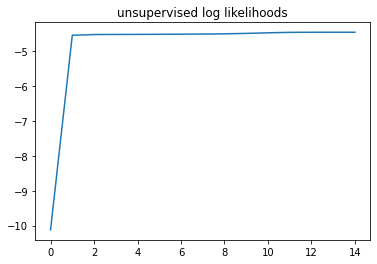

In [29]:
inits = FirstRandom()
pred, posterior, ll = Expectation_Maximazation(Data, inits)
print("total steps: ", len(ll))
plt.figure()
plt.plot(ll)
plt.title("unsupervised log likelihoods")
plt.show()
# khob hala badesh chi ? 😂 na k dare na kare khasi ru data mikone 😂😂

In [21]:

def GMM_sklearn(x, weights=None, means=None, covariances=None):
    model = GaussianMixture(n_components=2,
                            covariance_type='full',
                            tol=0.01,
                            max_iter=1000,
                            weights_init=weights,
                            means_init=means,
                            precisions_init=covariances)
    model.fit(x)
    print("\nscikit learn:\n\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (model.weights_[1], model.means_[0, :], model.means_[1, :], model.covariances_[0, :], model.covariances_[1, :]))
    return model.predict(x), model.predict_proba(x)[:,1]


def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params


def learn_params(x_labeled, y_labeled):
    n = x_labeled.shape[0]
    phi = x_labeled[y_labeled == 1].shape[0] / n
    mu0 = np.sum(x_labeled[y_labeled == 0], axis=0) / x_labeled[y_labeled == 0].shape[0]
    mu1 = np.sum(x_labeled[y_labeled == 1], axis=0) / x_labeled[y_labeled == 1].shape[0]
    sigma0 = np.cov(x_labeled[y_labeled == 0].T, bias= True)
    sigma1 = np.cov(x_labeled[y_labeled == 1].T, bias=True)
    return {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}


In [22]:
# Compare the forecats with Scikit-learn API
learned_params = learn_params(x, y)
weights = [1 - learned_params["phi"], learned_params["phi"]]
means = [learned_params["mu0"], learned_params["mu1"]]
covariances = [learned_params["sigma0"], learned_params["sigma1"]]
sklearn_forecasts, posterior_sklearn = GMM_sklearn(x_unlabeled, weights, means, covariances)

output_df = pd.DataFrame({'semisupervised_forecasts': semisupervised_forecasts,
                          'semisupervised_posterior': semisupervised_posterior[:, 1],
                          'sklearn_forecasts': sklearn_forecasts,
                          'posterior_sklearn': posterior_sklearn})

print("\n%s%% of forecasts matched." % (output_df[output_df["semisupervised_forecasts"] == output_df["sklearn_forecasts"]].shape[0] /output_df.shape[0] * 100))


/var/folders/gv/29bx0dbj5fvf2ql1sq4xwxsh0000gn/T/ipykernel_6902/2893065986.py:32: RuntimeWarning: invalid value encountered in double_scalars
  mu0 = np.sum(x_labeled[y_labeled == 0], axis=0) / x_labeled[y_labeled == 0].shape[0]
/var/folders/gv/29bx0dbj5fvf2ql1sq4xwxsh0000gn/T/ipykernel_6902/2893065986.py:33: RuntimeWarning: invalid value encountered in double_scalars
  mu1 = np.sum(x_labeled[y_labeled == 1], axis=0) / x_labeled[y_labeled == 1].shape[0]
/Users/saeed/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/saeed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/var/folders/gv/29bx0dbj5fvf2ql1sq4xwxsh0000gn/T/ipykernel_6902/2893065986.py:34: RuntimeWarning: Degrees of freedom <= 0 for slice
  sigma0 = np.cov(x_labeled[y_labeled == 0].T, bias= True)
/Users/saeed/opt/anaconda3/lib/python3.9/s

NameError: name 'x_unlabeled' is not defined